# **STA 141C Final Project**
## Pneumonia Prediction by X-Ray Imaging

Sung Woo Bak, Jonathan Casas-Ramirez, Adam Hetherwick, Jose Arreola Muñoz

Note: Due to the limitation of equipment, total dataset or subset dataset code is executed separately.


In [52]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Kaggle
os.environ['KAGGLE_USERNAME'] = "sungwoobak"
os.environ['KAGGLE_KEY'] = "2f7b029f03935cee9b45233ebef3e782"

import kaggle
import zipfile
import pandas as pd
import cv2
from cv2 import imread, IMREAD_GRAYSCALE, resize

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Tensorflow Keras API for Neural Network
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

#from tensorflow.keras.optimizers import Adam

In [4]:
# Download dataset
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset -p /content/datasets

# Unzip dataset
zip_path = '/content/datasets/coronahack-chest-xraydataset.zip'
unzip_path = '/content/datasets/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Dataset

### Subset

In [5]:
# Importing Dataset
meta = pd.read_csv('/content/datasets/Chest_xray_Corona_Metadata.csv')

In [28]:
# This part is for Subset of Train Data

train_sub = meta[meta.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_set = meta[meta.Dataset_type == 'TEST'].reset_index(drop=True)

normal_data = train_sub[train_sub['Label'] == 'Normal'].sample(n=1342, replace=False)
pneumonia_data = train_sub[train_sub['Label'] == 'Pnemonia'].sample(n=1342, replace=False)
bal_train = pd.concat([normal_data, pneumonia_data], axis=0).reset_index(drop=True)

train_label = bal_train['Label']
train_img = bal_train['X_ray_image_name']

test_label = test_set['Label']
test_img = test_set['X_ray_image_name']

# Directories
data_folder = '/content/datasets'
train_folder = '/content/datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'
test_folder = '/content/datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

train_path = []
for img in train_img:
  temp = train_folder + img
  train_path.append(temp)

test_path = []
for img in test_img:
  temp = test_folder + img
  test_path.append(temp)

In [66]:
test_set['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

### Total Dataset

In [ ]:
# Importing Dataset
meta = pd.read_csv('/content/datasets/Chest_xray_Corona_Metadata.csv')

# Train and Test set
train_set = meta[meta.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_set = meta[meta.Dataset_type == 'TEST'].reset_index(drop=True)

train_label = train_set['Label']
train_img = train_set['X_ray_image_name']

test_label = test_set['Label']
test_img = test_set['X_ray_image_name']

# Directories
data_folder = '/content/datasets'
train_folder = '/content/datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'
test_folder = '/content/datasets/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/'

train_path = []
for img in train_img:
  temp = train_folder + img
  train_path.append(temp)

test_path = []
for img in test_img:
  temp = test_folder + img
  test_path.append(temp)


# Train and Test set
train_set = meta[meta.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_set = meta[meta.Dataset_type == 'TEST'].reset_index(drop=True)

train_label = train_set['Label']
train_img = train_set['X_ray_image_name']

test_label = test_set['Label']
test_img = test_set['X_ray_image_name']

## Load/Preprocess Image Data

In [34]:
def load_image(img_path, size):
  '''
  load_image function takes the path of the image as input and returns the resized image.
  It uses the imread and resize functions from the cv2 library to read the image.
  Input : list of image paths
  targer : size of the image
  Output : list of resized images (a by a)
  '''
  # Load images
  images = []

  for index, path in enumerate(img_path):
    img = imread(path, IMREAD_GRAYSCALE)

    # Resize Images
    height, width = img.shape
    if width > height:
      new_width = int(width * (size / height))
      new_height = size
    else:
      new_width = size
      new_height = int(height * (size / width))

    resized_img = cv2.resize(img, (new_width, new_height))
    start_x = (new_width - size) // 2
    start_y = (new_height - size) // 2
    cropped_img = resized_img[start_y:start_y + size, start_x:start_x + size]

    images.append(cropped_img)

  # Image Normalization
  images = np.array(images)
  images = images.reshape(images.shape[0], size, size, 1).astype('float32') / 255

  return images

In [38]:
train_images = load_image(train_path, 128) # 128 by 128 Images
test_images = load_image(test_path, 128)
len(train_images), len(test_images)

(2684, 624)

## Convolution Neural Network using Tensorflow

In [39]:
# CNN
cnn = Sequential()

cnn.add(Conv2D(64,(3,3), input_shape=(128, 128, 1)))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64,(3,3)))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(64,(3,3)))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64,(3,3)))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(128))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(Dense(64))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(Dense(32))
cnn.add(Dropout(0.5))
cnn.add(LeakyReLU(alpha=0.2))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))

# Compile
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
train_labels = [1 if y == 'Pnemonia' else 0 for y in train_label]
test_labels = [1 if y == 'Pnemonia' else 0 for y in test_label]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [43]:
# EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

# Class Weight
class_weight = {0: (sum(train_labels == 0) / len(train_labels)), 1: (sum(train_labels == 1) / len(train_labels))}

# Train CNN Model
history = cnn.fit(train_images, train_labels, epochs=30, class_weight=class_weight, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/30
84/84 [==============================] - 10s 113ms/step - loss: 0.0496 - accuracy: 0.9728 - val_loss: 7.6514 - val_accuracy: 0.7324
Epoch 2/30
84/84 [==============================] - 9s 111ms/step - loss: 0.0497 - accuracy: 0.9713 - val_loss: 13.1854 - val_accuracy: 0.6987
Epoch 3/30
84/84 [==============================] - 9s 111ms/step - loss: 0.0357 - accuracy: 0.9776 - val_loss: 8.6210 - val_accuracy: 0.7228
Epoch 4/30
84/84 [==============================] - 9s 111ms/step - loss: 0.0340 - accuracy: 0.9806 - val_loss: 4.7064 - val_accuracy: 0.7853
Epoch 5/30
84/84 [==============================] - 9s 111ms/step - loss: 0.0420 - accuracy: 0.9829 - val_loss: 4.3811 - val_accuracy: 0.7837
Epoch 6/30
84/84 [==============================] - 9s 112ms/step - loss: 0.0218 - accuracy: 0.9873 - val_loss: 2.6063 - val_accuracy: 0.8173
Epoch 7/30
84/84 [==============================] - 9s 112ms/step - loss: 0.0554 - accuracy: 0.9694 - val_loss: 3.4280 - val_accuracy: 0.8029
Epoc

In [44]:
cnn.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 26ms/step - loss: 4.3174 - accuracy: 0.8285


[4.317407608032227, 0.8285256624221802]

## K-Fold Cross-Validation

In [54]:
kfold = KFold(n_splits=5, shuffle=True)
scores = []

for train_i, test_i in kfold.split(train_images):
  X_train, X_test = train_images[train_i], train_images[test_i]
  y_train, y_test = train_labels[train_i], train_labels[test_i]

  cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  history = cnn.fit(X_train, y_train, epochs=30, class_weight=class_weight, validation_data=(X_test, y_test))
  scores.append(cnn.evaluate(X_test, y_test)[1])

Epoch 1/30
68/68 [==============================] - 12s 133ms/step - loss: 0.0777 - accuracy: 0.9716 - val_loss: 1.8862 - val_accuracy: 0.8883
Epoch 2/30
68/68 [==============================] - 7s 108ms/step - loss: 0.0685 - accuracy: 0.9744 - val_loss: 0.2051 - val_accuracy: 0.9460
Epoch 3/30
68/68 [==============================] - 7s 108ms/step - loss: 0.0673 - accuracy: 0.9790 - val_loss: 0.0437 - val_accuracy: 0.9888
Epoch 4/30
68/68 [==============================] - 7s 108ms/step - loss: 0.0161 - accuracy: 0.9921 - val_loss: 0.1320 - val_accuracy: 0.9721
Epoch 5/30
68/68 [==============================] - 7s 109ms/step - loss: 0.0053 - accuracy: 0.9963 - val_loss: 0.0247 - val_accuracy: 0.9944
Epoch 6/30
68/68 [==============================] - 7s 109ms/step - loss: 0.0141 - accuracy: 0.9925 - val_loss: 0.0339 - val_accuracy: 0.9926
Epoch 7/30
68/68 [==============================] - 7s 109ms/step - loss: 0.0181 - accuracy: 0.9916 - val_loss: 0.1413 - val_accuracy: 0.9721
Epoch

0.976161801815033

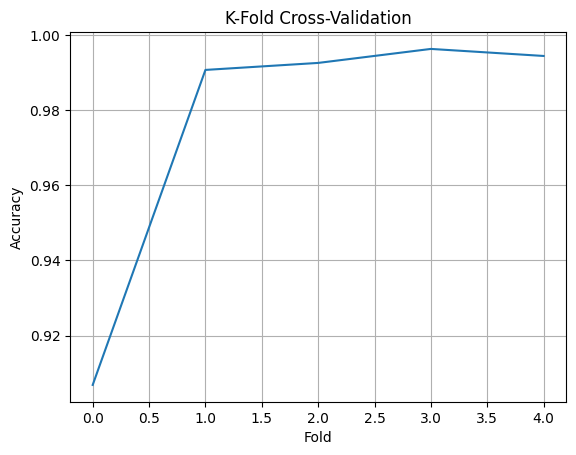

In [64]:
plt.plot(scores)
plt.title('K-Fold Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid()
sum(scores)/len(scores)

## Result

In [46]:
pred = cnn.predict(test_images)

20/20 [==============================] - 1s 25ms/step


In [47]:
threshold = 0.5
pred_labels = (pred > threshold).astype(int)

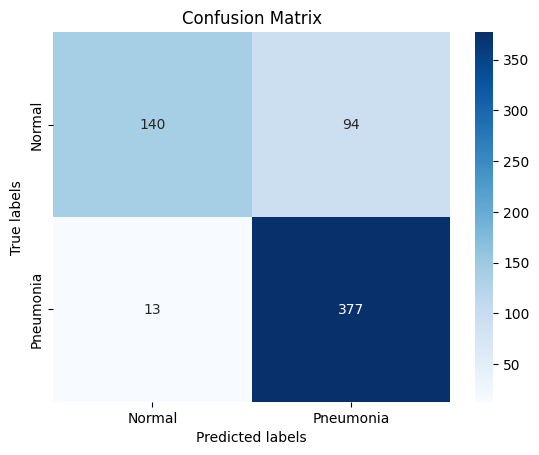

In [48]:
# Convert float into int
threshold = 0.5
pred_labels = (pred > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, pred_labels)

#Column = Pred 0 1
#Row = True 0 1

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

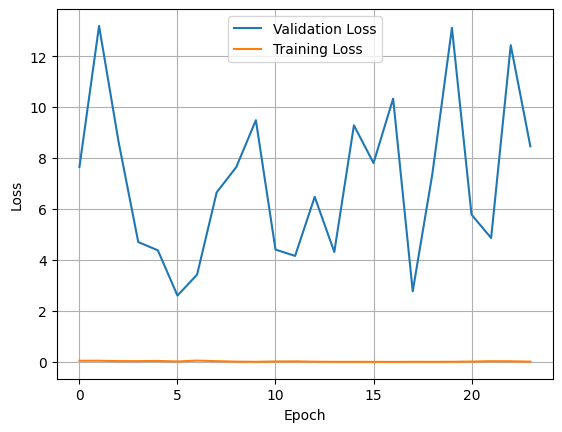

In [49]:
v_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(v_loss, label='Validation Loss')
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

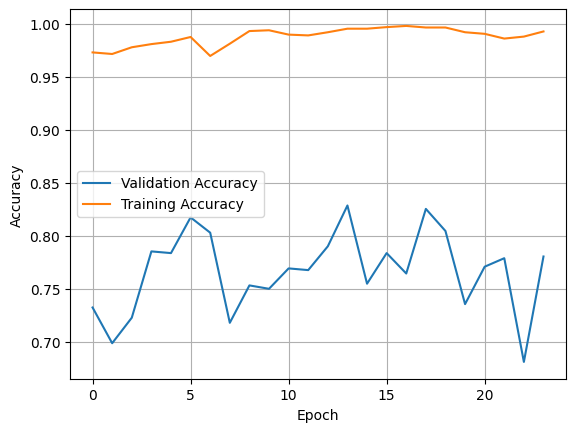

In [50]:
v_acc = history.history['val_accuracy']
acc = history.history['accuracy']

plt.plot(v_acc, label='Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

## Model Summary

In [51]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 124, 124, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 64)      256       
 chNormalization)                                       